<a href="https://colab.research.google.com/github/ChaerinKim12/codetree-TILs/blob/main/250903_%EC%B1%84%EB%A6%B01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 환경 설정

In [1]:
# 1
import torch
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"GPU 이름: {torch.cuda.get_device_name() if torch.cuda.is_available() else '없음'}")

# YOLOv8 설치
!pip install ultralytics

# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

CUDA 사용 가능: True
GPU 이름: NVIDIA A100-SXM4-40GB
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.7 MB/s eta 0:00:00
Mounted at /content/drive


### 데이터 경로 확인 및 폴더 생성

In [2]:
# 2
import os
import zipfile
import json
from PIL import Image
from ultralytics import YOLO

# 원본 데이터 경로
base_path = '/content/drive/MyDrive/dataset_mission1/detection'

# 압축파일 경로 확인
zip_paths = {
    'train_images': f'{base_path}/images/train/TS_KS.zip',
    'val_images': f'{base_path}/images/val/VS_KS.zip',
    'train_labels': f'{base_path}/labels/train/TL_KS_BBOX.zip',
    'val_labels': f'{base_path}/labels/val/VL_KS_BBOX.zip'
}

print('압축파일 존재 확인:')
for name, path in zip_paths.items():
    exists = os.path.exists(path)
    print(f"{name}: {'존재' if exists else '없음'}")

# YOLOv8 데이터셋 폴더 생성
yolo_path = '/content/yolo_dataset'
os.makedirs(f'{yolo_path}/images/train', exist_ok=True)
os.makedirs(f'{yolo_path}/images/val', exist_ok=True)
os.makedirs(f'{yolo_path}/labels/train', exist_ok=True)
os.makedirs(f'{yolo_path}/labels/val', exist_ok=True)

print("YOLOv8 폴더 구조 생성 완료")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
압축파일 존재 확인:
train_images: 존재
val_images: 존재
train_labels: 존재
val_labels: 존재
YOLOv8 폴더 구조 생성 완료


### 이미지 압축해제

In [3]:
# 3
import shutil

print("이미지 압축해제중")

# 이미지 압축해제 및 이동
image_zips = {
    'train': zip_paths['train_images'],
    'val': zip_paths['val_images']
}

for split, zip_path in image_zips.items():
    if os.path.exists(zip_path):
        print(f"{split} 이미지 압축해제 중...")

        # 임시 폴더에 압축해제
        temp_path = f'/content/temp_images_{split}'
        os.makedirs(temp_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_path)

        # 이미지 파일들을 YOLOv8 구조로 이동
        target_path = f'{yolo_path}/images/{split}'
        moved_count = 0

        for root, dirs, files in os.walk(temp_path):
            for file in files:
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    src_file = os.path.join(root, file)
                    dst_file = os.path.join(target_path, file)
                    shutil.move(src_file, dst_file)
                    moved_count += 1

        # 임시 폴더 삭제
        shutil.rmtree(temp_path)
        print(f"{split}: {moved_count}개 이미지 파일 이동 완료")

# 이미지 개수 확인
train_imgs = len([f for f in os.listdir(f'{yolo_path}/images/train') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
val_imgs = len([f for f in os.listdir(f'{yolo_path}/images/val') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
print(f"훈련 이미지: {train_imgs}개, 검증 이미지: {val_imgs}개")

이미지 압축해제중
train 이미지 압축해제 중...
train: 8052개 이미지 파일 이동 완료
val 이미지 압축해제 중...
val: 1006개 이미지 파일 이동 완료
훈련 이미지: 8052개, 검증 이미지: 1006개


### 라벨 압축해제

In [4]:
# 4
print("라벨 압축해제 시작...")

# 라벨 압축해제
label_zips = {
    'train': zip_paths['train_labels'],
    'val': zip_paths['val_labels']
}

for split, zip_path in label_zips.items():
    if os.path.exists(zip_path):
        print(f"{split} 라벨 압축해제 중...")

        # 임시 폴더에 압축해제
        temp_path = f'/content/temp_labels_{split}'
        os.makedirs(temp_path, exist_ok=True)

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(temp_path)

        # JSON 파일들을 라벨 폴더로 이동
        target_path = f'{yolo_path}/labels/{split}'
        moved_count = 0

        for root, dirs, files in os.walk(temp_path):
            for file in files:
                if file.lower().endswith('.json'):
                    src_file = os.path.join(root, file)
                    dst_file = os.path.join(target_path, file)
                    shutil.move(src_file, dst_file)
                    moved_count += 1

        # 임시 폴더 삭제
        shutil.rmtree(temp_path)
        print(f"{split}: {moved_count}개 JSON 라벨 파일 이동 완료")

# JSON 파일 개수 확인
train_jsons = len([f for f in os.listdir(f'{yolo_path}/labels/train') if f.endswith('.json')])
val_jsons = len([f for f in os.listdir(f'{yolo_path}/labels/val') if f.endswith('.json')])
print(f"훈련 JSON: {train_jsons}개, 검증 JSON: {val_jsons}개")

라벨 압축해제 시작...
train 라벨 압축해제 중...
train: 8052개 JSON 라벨 파일 이동 완료
val 라벨 압축해제 중...
val: 1006개 JSON 라벨 파일 이동 완료
훈련 JSON: 8052개, 검증 JSON: 1006개


### JSON -> YOLO

In [5]:
# 5
def convert_json_to_yolo_format(json_dir, images_dir, split_name):
    """
    JSON 라벨을 YOLO 형식으로 변환하는 함수
    """
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.json')]
    converted_count = 0

    print(f"{split_name} 변환 시작: {len(json_files)}개 파일")

    for i, json_file in enumerate(json_files):
        try:
            # JSON 파일 읽기
            json_path = os.path.join(json_dir, json_file)
            with open(json_path, 'r', encoding='utf-8') as f:
                data = json.load(f)

            # 이미지 정보 추출
            first_key = list(data.keys())[0]
            image_info = data[first_key]
            filename = image_info['filename']
            image_name = filename.split('.')[0]

            # 이미지 파일 찾기
            image_path = None
            for ext in ['.jpg', '.jpeg', '.png', '.bmp']:
                test_path = os.path.join(images_dir, image_name + ext)
                if os.path.exists(test_path):
                    image_path = test_path
                    break

            if image_path is None:
                continue

            # 이미지 크기 확인
            with Image.open(image_path) as img:
                img_width, img_height = img.size

            # YOLO 형식 변환
            yolo_lines = []
            for region in image_info.get('regions', []):
                shape = region['shape_attributes']

                if shape['name'] == 'rect':
                    # JSON 좌표를 YOLO 형식으로 변환
                    x = shape['x']
                    y = shape['y']
                    width = shape['width']
                    height = shape['height']

                    # 중심점 좌표 및 정규화
                    center_x = (x + width / 2) / img_width
                    center_y = (y + height / 2) / img_height
                    norm_width = width / img_width
                    norm_height = height / img_height

                    # 클래스 0 (굴뚝)으로 설정
                    yolo_line = f"0 {center_x:.6f} {center_y:.6f} {norm_width:.6f} {norm_height:.6f}"
                    yolo_lines.append(yolo_line)

            # YOLO txt 파일 저장
            txt_filename = image_name + '.txt'
            txt_path = os.path.join(json_dir, txt_filename)

            with open(txt_path, 'w') as f:
                f.write('\n'.join(yolo_lines))

            # 원본 JSON 파일 삭제
            os.remove(json_path)
            converted_count += 1

            # 진행률 표시
            if (i + 1) % 1000 == 0:
                print(f"  진행률: {i+1}/{len(json_files)}")

        except Exception as e:
            print(f"변환 실패 {json_file}: {e}")
            continue

    print(f"{split_name} 변환 완료: {converted_count}개 성공")
    return converted_count

# 훈련 및 검증 데이터 변환
train_converted = convert_json_to_yolo_format(
    f'{yolo_path}/labels/train',
    f'{yolo_path}/images/train',
    '훈련'
)

val_converted = convert_json_to_yolo_format(
    f'{yolo_path}/labels/val',
    f'{yolo_path}/images/val',
    '검증'
)

print(f"전체 변환 완료: 훈련 {train_converted}개, 검증 {val_converted}개")

훈련 변환 시작: 8052개 파일
  진행률: 1000/8052
  진행률: 2000/8052
  진행률: 3000/8052
  진행률: 4000/8052
  진행률: 5000/8052
  진행률: 6000/8052
  진행률: 7000/8052
  진행률: 8000/8052
훈련 변환 완료: 8052개 성공
검증 변환 시작: 1006개 파일
  진행률: 1000/1006
검증 변환 완료: 1006개 성공
전체 변환 완료: 훈련 8052개, 검증 1006개


### 데이터셋 설정 및 학습 시

In [6]:
# 6
# dataset.yaml 파일 생성
yaml_content = f"""# 굴뚝 탐지 데이터셋 (Kompsat-3/3A 위성이미지)
path: {yolo_path}
train: images/train
val: images/val

# 클래스 설정
nc: 1
names:
  0: chimney

# 데이터셋 정보
# 훈련 이미지: 8,052개
# 검증 이미지: 1,006개
# 목표: mAP@IoU=0.5 달성
"""

with open(f'{yolo_path}/dataset.yaml', 'w', encoding='utf-8') as f:
    f.write(yaml_content)

# 최종 데이터셋 상태 확인
final_train_imgs = len([f for f in os.listdir(f'{yolo_path}/images/train') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
final_val_imgs = len([f for f in os.listdir(f'{yolo_path}/images/val') if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
final_train_labels = len([f for f in os.listdir(f'{yolo_path}/labels/train') if f.endswith('.txt')])
final_val_labels = len([f for f in os.listdir(f'{yolo_path}/labels/val') if f.endswith('.txt')])

print("=== 최종 데이터셋 상태 ===")
print(f"훈련: 이미지 {final_train_imgs}개, 라벨 {final_train_labels}개")
print(f"검증: 이미지 {final_val_imgs}개, 라벨 {final_val_labels}개")

# YOLOv8 모델 로드 및 학습 설정
model = YOLO('yolov8n.pt')  # 가벼운 모델부터 시작

print("\n=== A100 GPU 최적화 학습 설정 ===")
print("YOLOv8 학습 시작 준비 완료!")

# A100에 최적화된 학습 파라미터
print("추천 학습 명령어:")
print("results = model.train(")
print("    data='/content/yolo_dataset/dataset.yaml',")
print("    epochs=200,")
print("    imgsz=640,")
print("    batch=32,")      # A100이므로 배치 크기 증가
print("    device=0,")      # GPU 사용
print("    patience=50,")   # 조기 종료 설정
print("    save_period=10") # 10 에포크마다 저장
print(")")

# 샘플 라벨 확인
if final_train_labels > 0:
    sample_files = [f for f in os.listdir(f'{yolo_path}/labels/train') if f.endswith('.txt')][:3]
    print(f"\n샘플 라벨 파일 확인:")
    for sample_file in sample_files:
        with open(f'{yolo_path}/labels/train/{sample_file}', 'r') as f:
            lines = f.readlines()
            print(f"{sample_file}: {len(lines)}개 객체")
            if lines:
                print(f"  첫 번째 객체: {lines[0].strip()}")

=== 최종 데이터셋 상태 ===
훈련: 이미지 8052개, 라벨 8052개
검증: 이미지 1006개, 라벨 1006개

=== A100 GPU 최적화 학습 설정 ===
YOLOv8 학습 시작 준비 완료!
추천 학습 명령어:
results = model.train(
    data='/content/yolo_dataset/dataset.yaml',
    epochs=200,
    imgsz=640,
    batch=32,
    device=0,
    patience=50,
    save_period=10
)

샘플 라벨 파일 확인:
K3A_CHN_20210508053003_62.txt: 2개 객체
  첫 번째 객체: 0 0.321289 0.746094 0.439453 0.105469
K3_CHN_20190325053242_6.txt: 1개 객체
  첫 번째 객체: 0 0.386719 0.430664 0.121094 0.083984
K3_CHN_20191030050122_57.txt: 1개 객체
  첫 번째 객체: 0 0.164062 0.323242 0.152344 0.150391


=== 데이터셋 품질 검증 ===


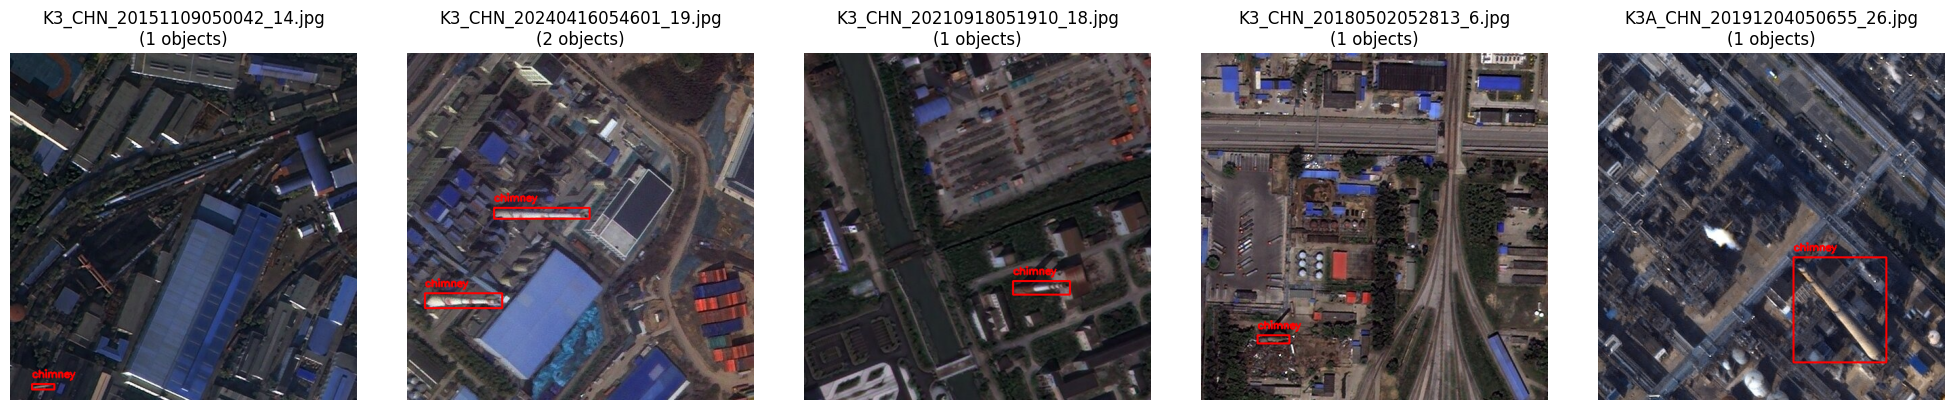

데이터셋 통계:
   총 객체 수: 10619개
   객체가 있는 이미지: 8052개
   이미지당 평균 객체 수: 1.32개


In [7]:
# 데이터 검증 셸
# ========== 새로운 셸: 데이터 품질 검증 ==========
import random
import matplotlib.pyplot as plt
import cv2

def validate_dataset_quality():
    """
    변환된 데이터셋의 품질을 검증하는 함수
    """
    print("=== 데이터셋 품질 검증 ===")

    # 랜덤하게 이미지 5개 선택해서 라벨 시각화
    train_images_dir = f'{yolo_path}/images/train'
    train_labels_dir = f'{yolo_path}/labels/train'

    image_files = [f for f in os.listdir(train_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    sample_images = random.sample(image_files, min(5, len(image_files)))

    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    if len(sample_images) == 1:
        axes = [axes]

    for i, img_file in enumerate(sample_images):
        # 이미지 로드
        img_path = os.path.join(train_images_dir, img_file)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]

        # 라벨 로드
        label_file = img_file.rsplit('.', 1)[0] + '.txt'
        label_path = os.path.join(train_labels_dir, label_file)

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()

            # 바운딩 박스 그리기
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id, cx, cy, bw, bh = map(float, parts)

                    # YOLO 형식을 픽셀 좌표로 변환
                    x1 = int((cx - bw/2) * w)
                    y1 = int((cy - bh/2) * h)
                    x2 = int((cx + bw/2) * w)
                    y2 = int((cy + bh/2) * h)

                    # 바운딩 박스 그리기
                    cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                    cv2.putText(img, 'chimney', (x1, y1-10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

        axes[i].imshow(img)
        axes[i].set_title(f'{img_file}\n({len(lines) if "lines" in locals() else 0} objects)')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # 통계 정보 출력
    total_objects = 0
    files_with_objects = 0

    for label_file in os.listdir(train_labels_dir):
        if label_file.endswith('.txt'):
            with open(os.path.join(train_labels_dir, label_file), 'r') as f:
                lines = f.readlines()
                if lines:
                    total_objects += len(lines)
                    files_with_objects += 1

    print(f"데이터셋 통계:")
    print(f"   총 객체 수: {total_objects}개")
    print(f"   객체가 있는 이미지: {files_with_objects}개")
    print(f"   이미지당 평균 객체 수: {total_objects/files_with_objects:.2f}개")

# 검증 실행
validate_dataset_quality()

### 학습 실행

In [8]:
# 7
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import clear_output
import time

def plot_real_time_training(results_dir):
    """
    학습 중 실시간으로 손실값과 메트릭을 보여주는 함수
    """
    results_csv = f'{results_dir}/results.csv'

    if not os.path.exists(results_csv):
        print("아직 results.csv 파일이 생성되지 않았습니다.")
        return

    try:
        # CSV 파일 읽기
        df = pd.read_csv(results_csv)
        df.columns = df.columns.str.strip()  # 컬럼명 공백 제거

        # 에포크 번호
        epochs = range(1, len(df) + 1)

        # 그래프 생성 (2행 5열)
        fig, axes = plt.subplots(2, 5, figsize=(20, 8))
        fig.suptitle(f'골목 탐지 모델 학습 진행상황 - Epoch {len(df)}', fontsize=16)

        # 첫 번째 행: 훈련 손실값들
        axes[0,0].plot(epochs, df['train/box_loss'], 'b-', linewidth=2)
        axes[0,0].set_title('Train Box Loss')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].grid(True, alpha=0.3)

        axes[0,1].plot(epochs, df['train/cls_loss'], 'g-', linewidth=2)
        axes[0,1].set_title('Train Classification Loss')
        axes[0,1].set_ylabel('Loss')
        axes[0,1].grid(True, alpha=0.3)

        axes[0,2].plot(epochs, df['train/dfl_loss'], 'r-', linewidth=2)
        axes[0,2].set_title('Train DFL Loss')
        axes[0,2].set_ylabel('Loss')
        axes[0,2].grid(True, alpha=0.3)

        axes[0,3].plot(epochs, df['metrics/precision(B)'], 'purple', linewidth=2)
        axes[0,3].set_title('Precision')
        axes[0,3].set_ylabel('Precision')
        axes[0,3].set_ylim(0, 1)
        axes[0,3].grid(True, alpha=0.3)

        axes[0,4].plot(epochs, df['metrics/recall(B)'], 'orange', linewidth=2)
        axes[0,4].set_title('Recall')
        axes[0,4].set_ylabel('Recall')
        axes[0,4].set_ylim(0, 1)
        axes[0,4].grid(True, alpha=0.3)

        # 두 번째 행: 검증 손실값과 mAP
        axes[1,0].plot(epochs, df['val/box_loss'], 'navy', linewidth=2)
        axes[1,0].set_title('Validation Box Loss')
        axes[1,0].set_xlabel('Epoch')
        axes[1,0].set_ylabel('Loss')
        axes[1,0].grid(True, alpha=0.3)

        axes[1,1].plot(epochs, df['val/cls_loss'], 'darkgreen', linewidth=2)
        axes[1,1].set_title('Validation Classification Loss')
        axes[1,1].set_xlabel('Epoch')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].grid(True, alpha=0.3)

        axes[1,2].plot(epochs, df['val/dfl_loss'], 'darkred', linewidth=2)
        axes[1,2].set_title('Validation DFL Loss')
        axes[1,2].set_xlabel('Epoch')
        axes[1,2].set_ylabel('Loss')
        axes[1,2].grid(True, alpha=0.3)

        axes[1,3].plot(epochs, df['metrics/mAP50(B)'], 'brown', linewidth=2)
        axes[1,3].set_title('mAP@0.5')
        axes[1,3].set_xlabel('Epoch')
        axes[1,3].set_ylabel('mAP')
        axes[1,3].set_ylim(0, 1)
        axes[1,3].grid(True, alpha=0.3)

        axes[1,4].plot(epochs, df['metrics/mAP50-95(B)'], 'black', linewidth=2)
        axes[1,4].set_title('mAP@0.5:0.95')
        axes[1,4].set_xlabel('Epoch')
        axes[1,4].set_ylabel('mAP')
        axes[1,4].set_ylim(0, 1)
        axes[1,4].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # 현재 성능 수치 출력
        latest = df.iloc[-1]
        print(f"\n=== 현재 성능 (Epoch {len(df)}) ===")
        print(f"mAP@0.5: {latest['metrics/mAP50(B)']:.4f}")
        print(f"mAP@0.5:0.95: {latest['metrics/mAP50-95(B)']:.4f}")
        print(f"Precision: {latest['metrics/precision(B)']:.4f}")
        print(f"Recall: {latest['metrics/recall(B)']:.4f}")
        print(f"Train Box Loss: {latest['train/box_loss']:.4f}")
        print(f"Val Box Loss: {latest['val/box_loss']:.4f}")

    except Exception as e:
        print(f"그래프 생성 중 오류: {e}")

print("실시간 모니터링 함수가 준비되었습니다!")

실시간 모니터링 함수가 준비되었습니다!


In [10]:
# 8
results = model.train(
    data='/content/yolo_dataset/dataset.yaml',
    epochs=300,
    imgsz=640,
    batch=16,
    device=0,
    patience=75,
    save_period=5,
    name='chimney_detection',
    lr0=0.001,
    weight_decay=0.0005, # 정규화 추가
    mosaic=0.8, # 데이터 증강
)


# 수정
print("학습이 완료되었습니다!")
print("결과는 /content/runs/detect/chimney_detection 폴더에 저장됨.")

Ultralytics 8.3.192 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=300, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=chimney_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=75, perspective=0.0, plo

In [10]:
import os
print("chimney_detection 폴더 확인:")
if os.path.exists('/content/runs/detect/chimney_detection'):
    print(os.listdir('/content/runs/detect/chimney_detection'))

print("\nchimney_detection2 폴더 확인:")
if os.path.exists('/content/runs/detect/chimney_detection2'):
    print(os.listdir('/content/runs/detect/chimney_detection2'))

print("\n전체 detect 폴더:")
print(os.listdir('/content/runs/detect'))

chimney_detection 폴더 확인:

chimney_detection2 폴더 확인:

전체 detect 폴더:


FileNotFoundError: [Errno 2] No such file or directory: '/content/runs/detect'

In [9]:
# ========== 9번째 셸: 실시간 모니터링 ==========
import matplotlib.pyplot as plt
import pandas as pd
import os

def check_training_progress():
    """
    현재 학습 진행상황을 확인하는 함수
    """
    results_csv = '/content/runs/detect/chimney_detection2/results.csv'

    if not os.path.exists(results_csv):
        print("아직 results.csv가 생성되지 않았습니다. 학습을 더 기다려주세요.")
        return

    # 제목을 영어로 변경 (가장 간단한 해결책)
    fig.suptitle(f'Chimney Detection Training - Epoch {current_epoch}/300', fontsize=14)

    # 그래프 제목들도 영어로
    axes[0].set_title('Box Loss (Position Error)')
    axes[1].set_title('Class Loss (Classification Error)')
    axes[2].set_title('mAP@0.5 (Performance)')

    # 결과 데이터 읽기
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()

    current_epoch = len(df)
    epochs = range(1, current_epoch + 1)

    # 그래프 그리기
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'굴뚝 탐지 학습 현황 - Epoch {current_epoch}/300', fontsize=14)

    # Box Loss
    axes[0].plot(epochs, df['train/box_loss'], 'b-', linewidth=2, label='Train')
    if 'val/box_loss' in df.columns:
        axes[0].plot(epochs, df['val/box_loss'], 'r--', linewidth=2, label='Val')
    axes[0].set_title('Box Loss (위치 예측 오류)')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Class Loss
    axes[1].plot(epochs, df['train/cls_loss'], 'g-', linewidth=2, label='Train')
    if 'val/cls_loss' in df.columns:
        axes[1].plot(epochs, df['val/cls_loss'], 'orange', linestyle='--', linewidth=2, label='Val')
    axes[1].set_title('Class Loss (분류 오류)')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # mAP (성능 지표)
    if 'metrics/mAP50(B)' in df.columns and current_epoch > 1:
        axes[2].plot(epochs, df['metrics/mAP50(B)'], 'purple', linewidth=2)
        axes[2].set_title('mAP@0.5 (최종 성능)')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('mAP')
        axes[2].set_ylim(0, 1)
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'mAP는 검증 시작 후\n표시됩니다',
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].set_title('mAP@0.5 (대기중)')

    plt.tight_layout()
    plt.show()

    # 현재 상태 출력
    latest = df.iloc[-1]
    print(f"\n=== 현재 학습 상태 (Epoch {current_epoch}) ===")
    print(f"Box Loss: {latest['train/box_loss']:.4f}")
    print(f"Class Loss: {latest['train/cls_loss']:.4f}")
    print(f"DFL Loss: {latest['train/dfl_loss']:.4f}")

    if 'metrics/mAP50(B)' in df.columns and current_epoch > 1:
        if not pd.isna(latest['metrics/mAP50(B)']):
            print(f"mAP@0.5: {latest['metrics/mAP50(B)']:.4f}")

# 모니터링 실행
check_training_progress()

아직 results.csv가 생성되지 않았습니다. 학습을 더 기다려주세요.


In [7]:
# ========== 10번째 셸: 학습 완료 후 최종 결과 분석 ==========
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

def create_final_analysis():
    """
    학습 완료 후 최종 결과 분석
    """
    results_dir = '/content/runs/detect/chimney_detection2'  # alley -> chimney 수정
    results_csv = f'{results_dir}/results.csv'

    if not os.path.exists(results_csv):
        print("결과 파일을 찾을 수 없습니다.")
        return

    # 결과 데이터 로드
    df = pd.read_csv(results_csv)
    df.columns = df.columns.str.strip()

    print("=== 최종 학습 결과 분석 ===")

    # 최고 성능 찾기
    best_mAP50_idx = df['metrics/mAP50(B)'].idxmax()
    best_mAP50 = df.loc[best_mAP50_idx]

    best_mAP50_95_idx = df['metrics/mAP50-95(B)'].idxmax()
    best_mAP50_95 = df.loc[best_mAP50_95_idx]

    print(f"최고 mAP@0.5: {best_mAP50['metrics/mAP50(B)']:.4f} (Epoch {best_mAP50_idx + 1})")
    print(f"최고 mAP@0.5:0.95: {best_mAP50_95['metrics/mAP50-95(B)']:.4f} (Epoch {best_mAP50_95_idx + 1})")

    # 최종 성능
    final_results = df.iloc[-1]
    print(f"\n최종 성능 (Epoch {len(df)}):")
    print(f"   mAP@0.5: {final_results['metrics/mAP50(B)']:.4f}")
    print(f"   mAP@0.5:0.95: {final_results['metrics/mAP50-95(B)']:.4f}")
    print(f"   Precision: {final_results['metrics/precision(B)']:.4f}")
    print(f"   Recall: {final_results['metrics/recall(B)']:.4f}")

    # 수렴성 분석
    last_10_mAP = df['metrics/mAP50(B)'].tail(10)
    mAP_std = last_10_mAP.std()

    if mAP_std < 0.01:
        print(f"모델이 잘 수렴했습니다 (마지막 10 에포크 mAP 표준편차: {mAP_std:.4f})")
    else:
        print(f"모델이 아직 수렴 중일 수 있습니다 (마지막 10 에포크 mAP 표준편차: {mAP_std:.4f})")

    # 저장된 모델 파일 확인
    best_model_path = f'{results_dir}/weights/best.pt'
    last_model_path = f'{results_dir}/weights/last.pt'

    print(f"\n저장된 모델:")
    print(f"   최고 성능 모델: {best_model_path}")
    print(f"   마지막 모델: {last_model_path}")

    return df

# 실행 (학습 완료 후)
print("학습 완료 후 이 함수를 실행하세요:")
print("final_df = create_final_analysis()")

학습 완료 후 이 함수를 실행하세요:
final_df = create_final_analysis()


In [8]:
# ========== 11번째 셸: 학습된 모델로 테스트 및 추론 ==========
from ultralytics import YOLO
import os

def test_trained_model():
    """
    학습된 모델로 테스트 이미지에서 굴뚝 탐지 수행
    """
    # 최고 성능 모델 로드
    best_model_path = '/content/runs/detect/chimney_detection2/weights/best.pt'  # alley -> chimney 수정

    if not os.path.exists(best_model_path):
        print("학습된 모델을 찾을 수 없습니다. 학습을 먼저 완료해주세요.")
        return

    model = YOLO(best_model_path)

    # 검증 데이터셋으로 성능 평가
    print("검증 데이터셋으로 모델 성능 평가 중...")
    results = model.val(data='/content/yolo_dataset/dataset.yaml')

    print(f"최종 검증 결과:")
    print(f"   mAP@0.5: {results.box.map50:.4f}")
    print(f"   mAP@0.5:0.95: {results.box.map:.4f}")

    # 몇 개 테스트 이미지로 추론 테스트
    test_images_dir = '/content/yolo_dataset/images/val'
    test_images = [f for f in os.listdir(test_images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if test_images:
        print(f"\n샘플 이미지 {min(3, len(test_images))}개로 추론 테스트:")

        for i in range(min(3, len(test_images))):
            img_path = os.path.join(test_images_dir, test_images[i])
            results = model.predict(img_path, conf=0.25)  # 신뢰도 25% 이상만

            detections = len(results[0].boxes) if results[0].boxes is not None else 0
            print(f"   {test_images[i]}: {detections}개 굴뚝 탐지")  # 골목 -> 굴뚝 수정

    print(f"\n모델 테스트 완료!")
    return model

# 실행 (학습 완료 후)
print("학습 완료 후 이 함수를 실행하세요:")
print("trained_model = test_trained_model()")

학습 완료 후 이 함수를 실행하세요:
trained_model = test_trained_model()
